In [4]:
from google.cloud import bigquery
import pandas as pd
import os

# Configurer la clé JSON pour l'authentification
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "my-project-tp-447313-3bc2aa50dafc.json"

# Initialiser le client BigQuery
client = bigquery.Client()

# Charger les données à partir de BigQuery
project_id = "my-project-tp-447313"
dataset_id = "myprojecttp447313"
table_id = "covid_data"
full_table_id = f"{project_id}.{dataset_id}.{table_id}"

# Inspection initiale des données
query_inspect = f"""
SELECT 
    COUNT(*) AS total_rows,
    SUM(CASE WHEN value IS NULL THEN 1 ELSE 0 END) AS null_values,
    SUM(CASE WHEN url IS NULL THEN 1 ELSE 0 END) AS null_urls,
    MIN(date) AS earliest_date,
    MAX(date) AS latest_date,
    COUNT(DISTINCT country) AS unique_countries
FROM `{full_table_id}`
"""

# Exécuter la requête pour l'inspection
inspect_job = client.query(query_inspect)
inspection_results = inspect_job.to_dataframe()
print("Inspection des données :")
print(inspection_results)

# Requête pour extraire et transformer les données
query = f"""
SELECT 
    country,
    indicator,
    DATE(date) AS date,
    EXTRACT(YEAR FROM DATE(date)) AS year,
    EXTRACT(WEEK FROM DATE(date)) AS week,
    value
FROM `{full_table_id}`
WHERE value IS NOT NULL
"""

# Exécuter la requête et charger les données dans un DataFrame Pandas
query_job = client.query(query)
data = query_job.to_dataframe()

# Tri des données par pays et date pour assurer une bonne structure
data = data.sort_values(by=['country', 'date'])

# Affichage des premières lignes pour vérification
print(data.head())


/home/browngreg/hetic/bigdata/c_dataset/myenv/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Inspection des données :
   total_rows  null_values  null_urls earliest_date latest_date  \
0       28337            0      19997    2020-01-05  2023-11-26   

   unique_countries  
0                25  


/home/browngreg/hetic/bigdata/c_dataset/myenv/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


      country                 indicator        date  year  week  value
6597  Austria  Daily hospital occupancy  2020-04-01  2020    13  856.0
7783  Austria       Daily ICU occupancy  2020-04-01  2020    13  215.0
6598  Austria  Daily hospital occupancy  2020-04-02  2020    13  823.0
7784  Austria       Daily ICU occupancy  2020-04-02  2020    13  219.0
6599  Austria  Daily hospital occupancy  2020-04-03  2020    13  829.0


#### **1. Analyse temporelle des cas et vaccinations**

/home/browngreg/hetic/bigdata/c_dataset/myenv/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Aperçu des données :
   country                 indicator        date  total_value
0  Estonia  Daily hospital occupancy  2020-01-06          1.0
1  Estonia  Daily hospital occupancy  2020-01-18          1.0
2  Estonia  Daily hospital occupancy  2020-02-12          1.0
3  Estonia  Daily hospital occupancy  2020-02-25          1.0
4  Estonia  Daily hospital occupancy  2020-02-26          1.0


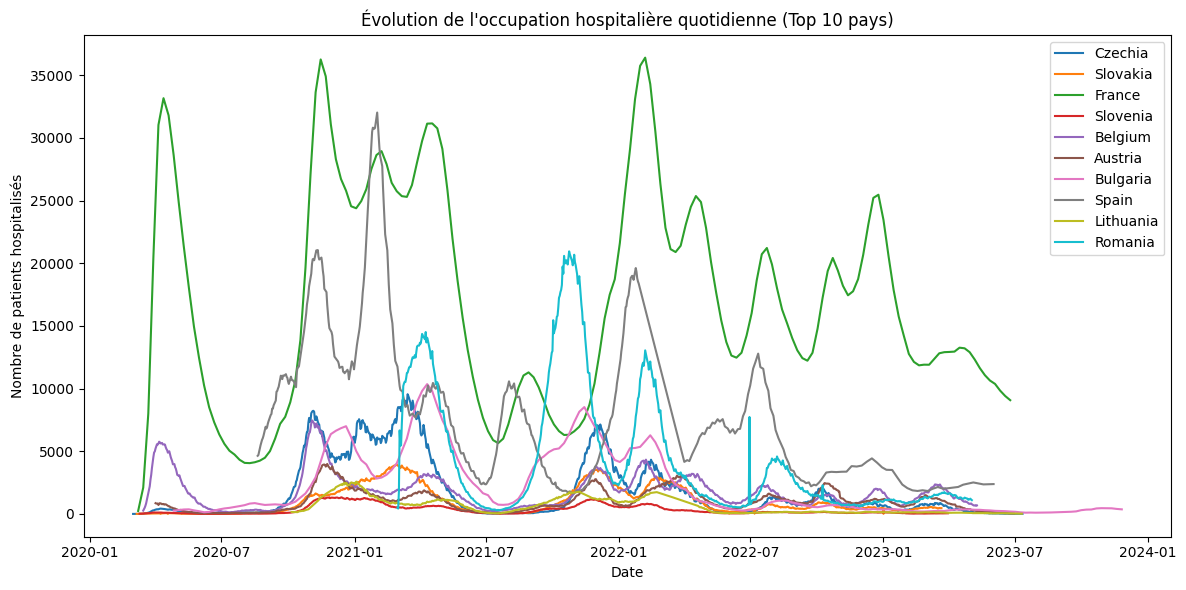

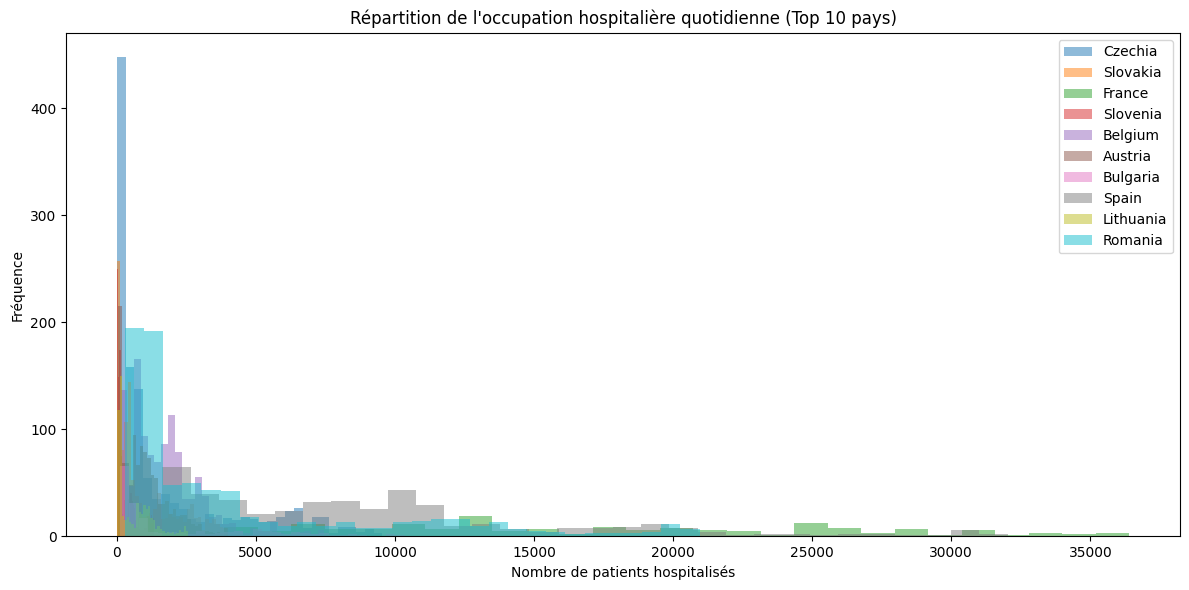

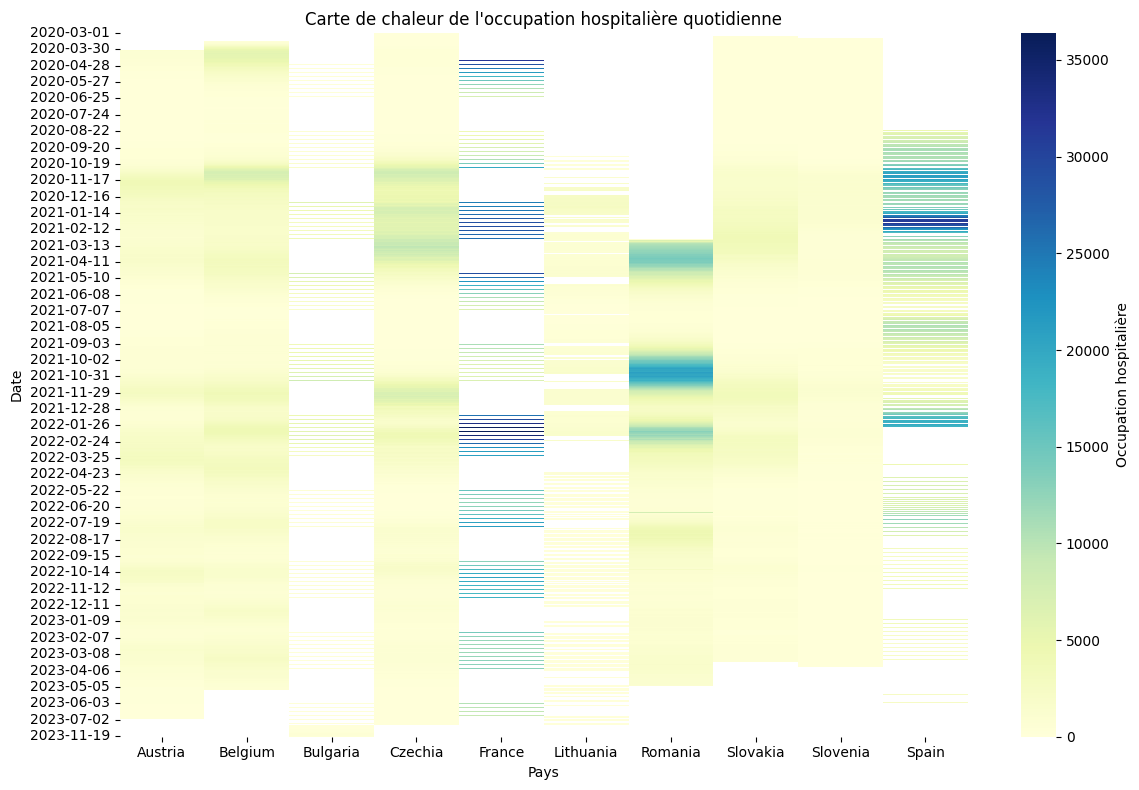

/tmp/ipykernel_137287/3878806427.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['daily_change'] = filtered_data.groupby('country')['total_value'].diff()


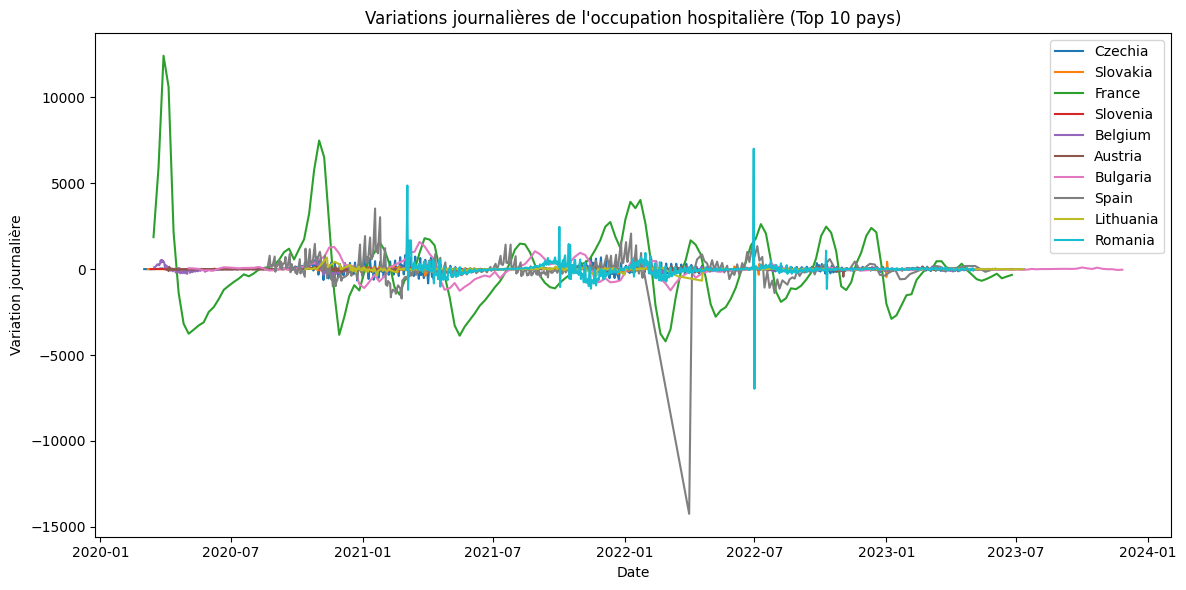

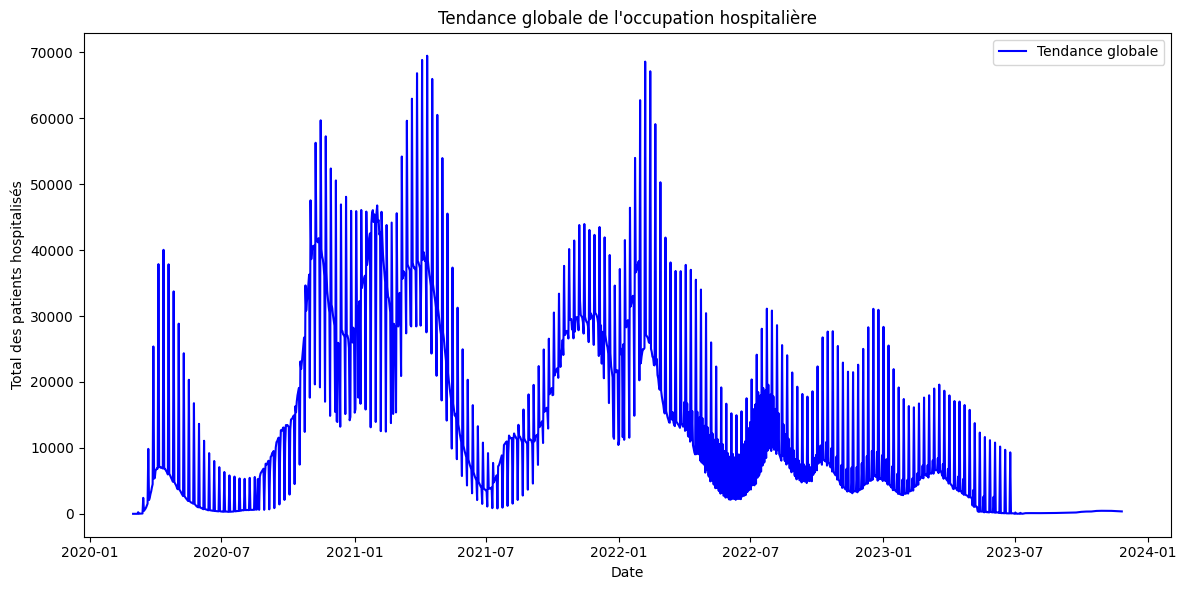

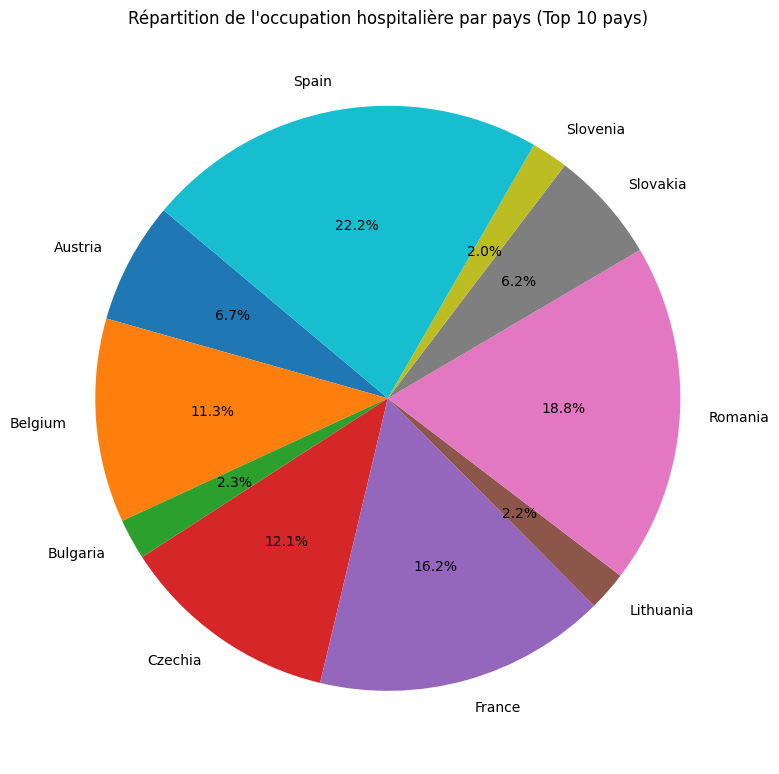

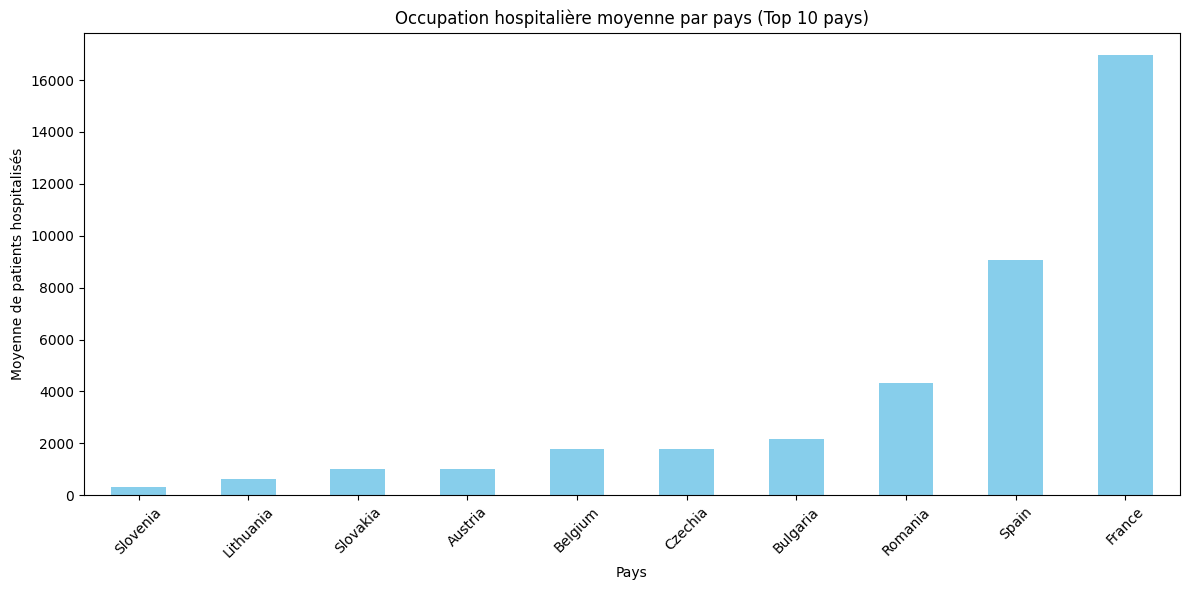

/tmp/ipykernel_137287/3878806427.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['daily_change'] = filtered_data.groupby('country')['total_value'].diff()


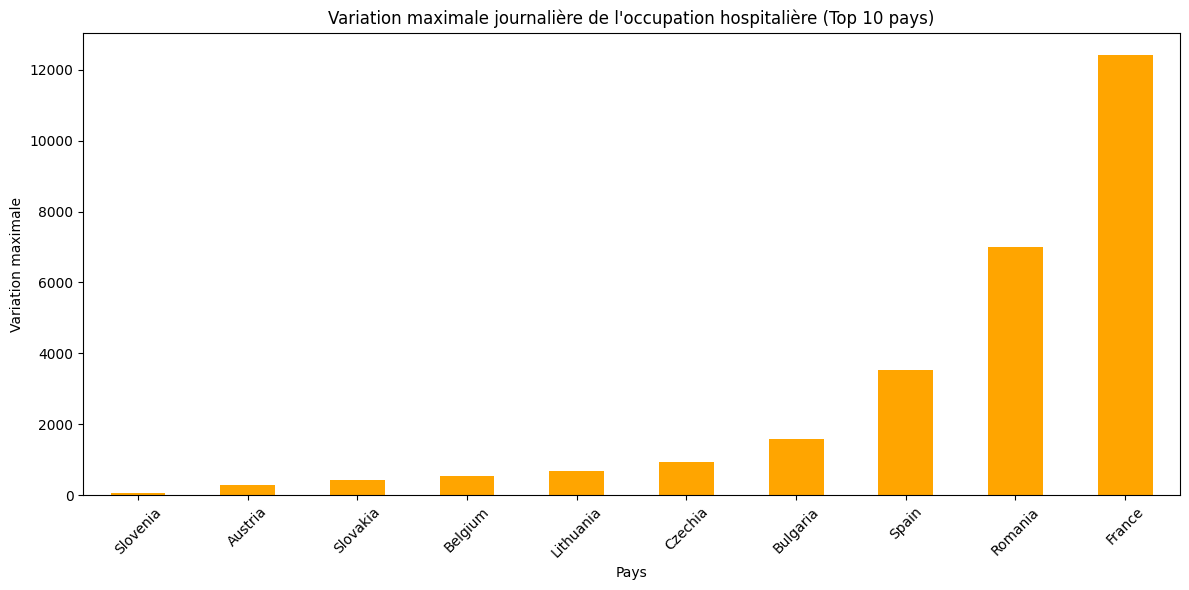

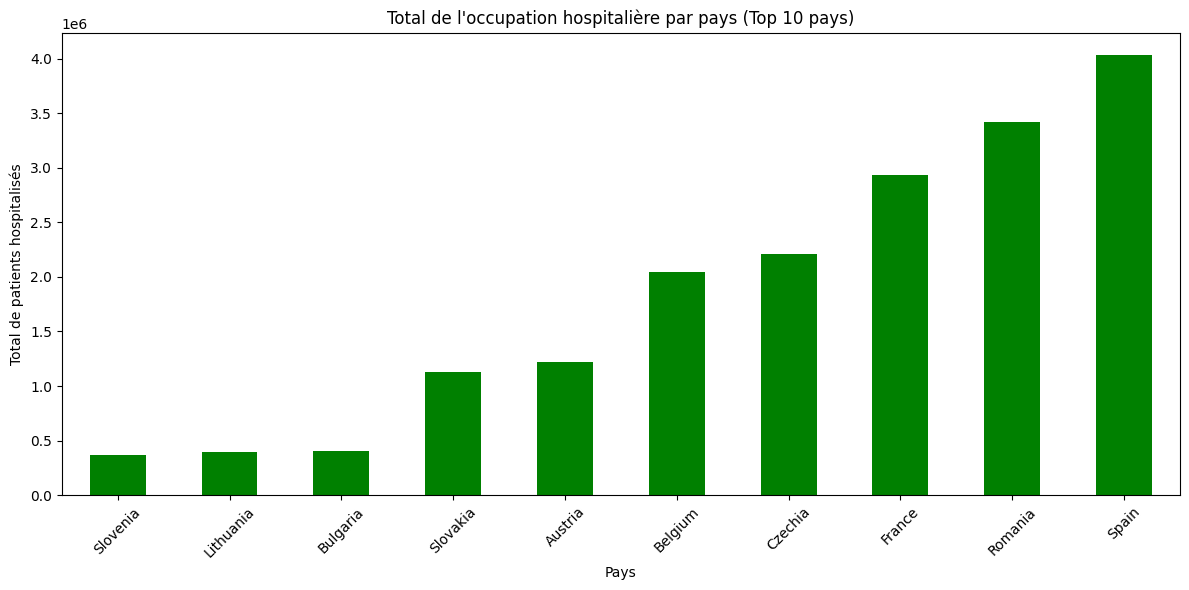

/tmp/ipykernel_137287/3878806427.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month'] = pd.to_datetime(filtered_data['date']).dt.to_period('M')


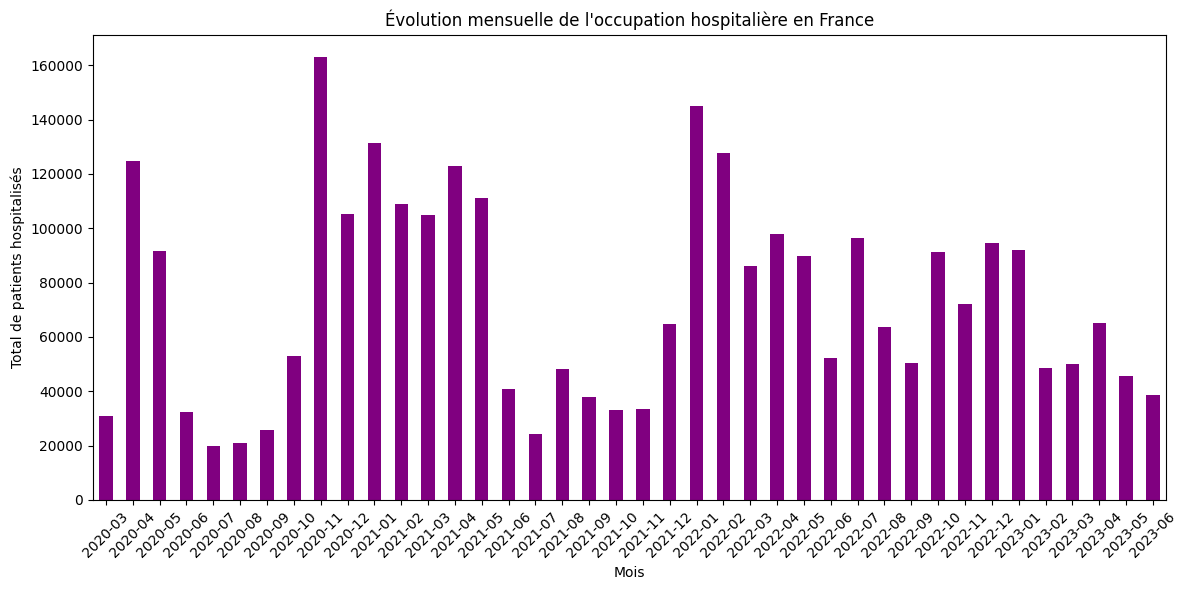

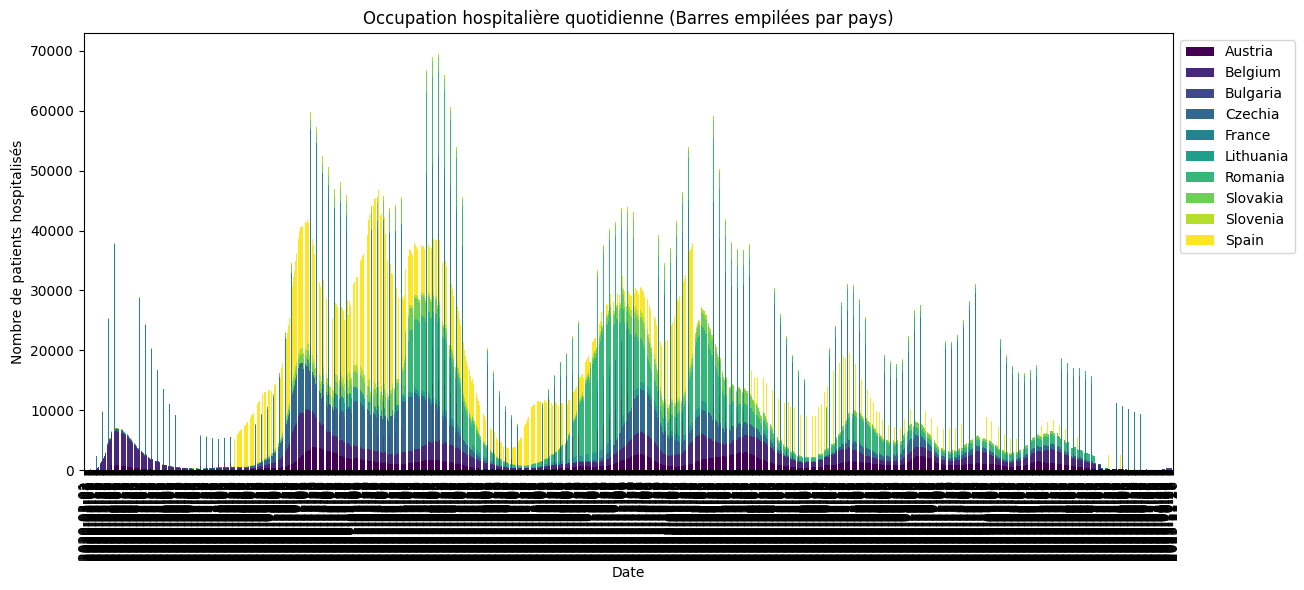

Résumé statistique par pays :
            count          mean          std     min       25%      50%  \
country                                                                   
Austria    1186.0   1027.731872   847.057518    39.0    323.75    865.5   
Belgium    1152.0   1778.126736  1357.735909   130.0    740.50   1538.5   
Bulgaria    188.0   2175.234043  2567.322569    98.0    346.50    740.5   
Czechia    1229.0   1794.789260  2378.689225     0.0    129.00    666.0   
France      173.0  16972.722543  8683.358624   238.0  10254.00  15441.0   
Lithuania   614.0    642.760586   640.200978    16.0    115.00    385.0   
Romania     794.0   4308.201511  4993.117202   291.0    990.25   1768.0   
Slovakia   1112.0   1011.576439  1081.347134     1.0    170.75    495.5   
Slovenia   1117.0    327.253357   371.073831     5.0     56.00    131.0   
Spain       445.0   9064.970787  6458.304039  1640.0   3847.00   7924.0   

               75%      max  
country                      
Austria  

In [5]:
from google.cloud import bigquery
import pandas as pd
import os
import matplotlib.pyplot as plt

# Configurer la clé JSON pour l'authentification
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "my-project-tp-447313-3bc2aa50dafc.json"

# Initialiser le client BigQuery
client = bigquery.Client()

# Requête pour analyser 'Daily hospital occupancy'
query_analysis = f"""
SELECT 
    country,
    indicator,
    DATE(date) AS date,
    SUM(value) AS total_value
FROM `my-project-tp-447313.myprojecttp447313.covid_data`
WHERE indicator = 'Daily hospital occupancy'
GROUP BY country, indicator, DATE(date)
ORDER BY date
"""

# Exécuter la requête
query_job = client.query(query_analysis)
analysis_data = query_job.to_dataframe()

# Vérifier les données
print("Aperçu des données :")
print(analysis_data.head())

# Étape 1 : Filtrer les 10 pays avec les valeurs totales les plus élevées
top_countries = analysis_data.groupby('country')['total_value'].sum().nlargest(10).index
filtered_data = analysis_data[analysis_data['country'].isin(top_countries)]

# Étape 2 : Visualisation de l'évolution par pays
plt.figure(figsize=(12, 6))
for country in filtered_data['country'].unique():
    country_data = filtered_data[filtered_data['country'] == country]
    plt.plot(country_data['date'], country_data['total_value'], label=country)

plt.title("Évolution de l'occupation hospitalière quotidienne (Top 10 pays)")
plt.xlabel("Date")
plt.ylabel("Nombre de patients hospitalisés")
plt.legend()
plt.tight_layout()
plt.show()


# Histogramme de répartition pour les 10 pays principaux
plt.figure(figsize=(12, 6))
for country in filtered_data['country'].unique():
    country_data = filtered_data[filtered_data['country'] == country]
    plt.hist(country_data['total_value'], bins=30, alpha=0.5, label=country)

plt.title("Répartition de l'occupation hospitalière quotidienne (Top 10 pays)")
plt.xlabel("Nombre de patients hospitalisés")
plt.ylabel("Fréquence")
plt.legend()
plt.tight_layout()
plt.show()

# Préparer les données pour la heatmap
heatmap_data = filtered_data.pivot(index='date', columns='country', values='total_value')

# Heatmap avec seaborn
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label': 'Occupation hospitalière'})
plt.title("Carte de chaleur de l'occupation hospitalière quotidienne")
plt.xlabel("Pays")
plt.ylabel("Date")
plt.tight_layout()
plt.show()

# Calcul des variations journalières
filtered_data['daily_change'] = filtered_data.groupby('country')['total_value'].diff()

# Visualisation des variations journalières
plt.figure(figsize=(12, 6))
for country in filtered_data['country'].unique():
    country_data = filtered_data[filtered_data['country'] == country]
    plt.plot(country_data['date'], country_data['daily_change'], label=country)

plt.title("Variations journalières de l'occupation hospitalière (Top 10 pays)")
plt.xlabel("Date")
plt.ylabel("Variation journalière")
plt.legend()
plt.tight_layout()
plt.show()


# Calcul des tendances globales
global_trend = filtered_data.groupby('date')['total_value'].sum()

# Visualisation des tendances globales
plt.figure(figsize=(12, 6))
plt.plot(global_trend.index, global_trend.values, label='Tendance globale', color='blue')
plt.title("Tendance globale de l'occupation hospitalière")
plt.xlabel("Date")
plt.ylabel("Total des patients hospitalisés")
plt.legend()
plt.tight_layout()
plt.show()


# Somme totale par pays
country_totals = filtered_data.groupby('country')['total_value'].sum()

# Graphique en secteurs
plt.figure(figsize=(8, 8))
plt.pie(country_totals, labels=country_totals.index, autopct='%1.1f%%', startangle=140)
plt.title("Répartition de l'occupation hospitalière par pays (Top 10 pays)")
plt.tight_layout()
plt.show()


# Moyenne d'occupation hospitalière par pays
avg_occupancy = filtered_data.groupby('country')['total_value'].mean()

# Graphique en barres
plt.figure(figsize=(12, 6))
avg_occupancy.sort_values().plot(kind='bar', color='skyblue')
plt.title("Occupation hospitalière moyenne par pays (Top 10 pays)")
plt.xlabel("Pays")
plt.ylabel("Moyenne de patients hospitalisés")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calcul des variations journalières
filtered_data['daily_change'] = filtered_data.groupby('country')['total_value'].diff()

# Variation maximale par pays
max_variation = filtered_data.groupby('country')['daily_change'].max()

# Graphique en barres
plt.figure(figsize=(12, 6))
max_variation.sort_values().plot(kind='bar', color='orange')
plt.title("Variation maximale journalière de l'occupation hospitalière (Top 10 pays)")
plt.xlabel("Pays")
plt.ylabel("Variation maximale")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total d'occupation hospitalière par pays
total_occupancy = filtered_data.groupby('country')['total_value'].sum()

# Graphique en barres
plt.figure(figsize=(12, 6))
total_occupancy.sort_values().plot(kind='bar', color='green')
plt.title("Total de l'occupation hospitalière par pays (Top 10 pays)")
plt.xlabel("Pays")
plt.ylabel("Total de patients hospitalisés")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Exemple pour un pays spécifique (France)
filtered_data['month'] = pd.to_datetime(filtered_data['date']).dt.to_period('M')
country_data = filtered_data[filtered_data['country'] == 'France']
monthly_totals = country_data.groupby('month')['total_value'].sum()

# Graphique en barres
plt.figure(figsize=(12, 6))
monthly_totals.plot(kind='bar', color='purple')
plt.title("Évolution mensuelle de l'occupation hospitalière en France")
plt.xlabel("Mois")
plt.ylabel("Total de patients hospitalisés")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Préparer les données pour un graphique en barres empilées
stacked_data = filtered_data.groupby(['date', 'country'])['total_value'].sum().unstack().fillna(0)

# Graphique en barres empilées
stacked_data.plot(kind='bar', stacked=True, figsize=(12, 6), width=0.8, colormap='viridis')
plt.title("Occupation hospitalière quotidienne (Barres empilées par pays)")
plt.xlabel("Date")
plt.ylabel("Nombre de patients hospitalisés")
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



# Étape 3 : Résumé statistique (optionnel)
summary = filtered_data.groupby('country')['total_value'].describe()
print("Résumé statistique par pays :")
print(summary)


